# Sentiment Analysis using Recurrent Neural Networks

### Sentiment analysis can be thought of as the exercise of taking a sentence, paragraph, document, or any piece of natural language, and determining whether that text's emotional tone is positive or negative. We will be applying the concepts of natural language processing to identify the sentiment of the given text.

We'll authenticate the google drive and create connection with google colaboratory.

if pydrive is not installed then install pydrive with command

**!pip install pydrive**

In [0]:
!pip install pydrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
import tensorflow as tf
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Make the parent folder shareable and write the id of parent file to get all the files from the folder

In [0]:
file_list = drive.ListFile({'q': "'189H9l-4H8q_EYUfyIQSvzl9lCXngGJDJ' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: aclImdb.zip, id: 1jGazigaA-9HD91j6YMOn4rGDqu8YKDDj


In [0]:
zip_file = drive.CreateFile({'id': '1jGazigaA-9HD91j6YMOn4rGDqu8YKDDj'})
zip_file.GetContentFile('aclImdb.zip')

In [0]:
!unzip 'aclImdb.zip'

## Loading Word Vectors

For simplicity, we're going to use a pretrained word vector model. As one of the biggest players in the ML game, Google was able to train a Word2Vec model on a massive Google News dataset that contained over 100 billion different words! 
We'd use those vectors, but since the word vectors matrix is quite large, we'll use a much smaller matrix that is trained using GloVe. The matrix will contain 400,000 word vectors, each with a dimensionality of 50. 

We're going to be importing two different data structures, one will be a Python list with the 400,000 words, and one will be a 400,000 x 50 dimensional embedding matrix that holds all of the word vector values. 

In [2]:
import numpy as np
wordsList = np.load('aclImdb/wordsList.npy')
print('Loaded the word list!')
wordsList = wordsList.tolist() #Originally loaded as numpy array
wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8
wordVectors = np.load('aclImdb/wordVectors.npy')
print ('Loaded the word vectors!')

Loaded the word list!
Loaded the word vectors!


Let's take a look at the dimentionality of vocabulary list and word embedding matrix size

In [3]:
print(len(wordsList))
print(wordVectors.shape)

400000
(400000, 50)


We can see how a word is represented in the word list.
Lets check the check the word vector for 'happy'

In [0]:
baseballIndex = wordsList.index('happy')
wordVectors[baseballIndex]

array([ 0.092086,  0.2571  , -0.58693 , -0.37029 ,  1.0828  , -0.55466 ,
       -0.78142 ,  0.58696 , -0.58714 ,  0.46318 , -0.11267 ,  0.2606  ,
       -0.26928 , -0.072466,  1.247   ,  0.30571 ,  0.56731 ,  0.30509 ,
       -0.050312, -0.64443 , -0.54513 ,  0.86429 ,  0.20914 ,  0.56334 ,
        1.1228  , -1.0516  , -0.78105 ,  0.29656 ,  0.7261  , -0.61392 ,
        2.4225  ,  1.0142  , -0.17753 ,  0.4147  , -0.12966 , -0.47064 ,
        0.3807  ,  0.16309 , -0.323   , -0.77899 , -0.42473 , -0.30826 ,
       -0.42242 ,  0.055069,  0.38267 ,  0.037415, -0.4302  , -0.39442 ,
        0.10511 ,  0.87286 ], dtype=float32)

## Loading Data

There are total 25000 movie reviews for training, 12500 reviews are positive and 12500 negative reviews. This set has 25,000 movie reviews, with 12,500 positive reviews and 12,500 negative reviews. Each of the reviews is stored in a txt file that we need to parse through. The positive reviews are stored in one directory and the negative reviews are stored in another. The following piece of code will determine total and average number of words in each review.

In [4]:
from os import listdir
from os.path import isfile, join
positiveFiles = ['aclImdb/train/pos/'
                 + f for f in listdir('aclImdb/train/pos')
                 if isfile(join('aclImdb/train/pos', f))]

# positiveFiles_test = ['aclImdb/test/pos/'
#                  + f for f in listdir('aclImdb/test/pos')
#                  if isfile(join('aclImdb/test/pos', f))]

# total_pos = positiveFiles + positiveFiles_test

negativeFiles = ['aclImdb/train/neg/'
                 + f for f in listdir('aclImdb/train/neg/') 
                 if isfile(join('aclImdb/train/neg/', f))]

# negativeFiles_test = ['aclImdb/test/neg/'
#                  + f for f in listdir('aclImdb/test/neg/') 
#                  if isfile(join('aclImdb/test/neg/', f))]

# total_neg =  negativeFiles_test + negativeFiles

numWords = []
for pf in positiveFiles:
    with open(pf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)       
print('Positive files finished')

for nf in negativeFiles:
    with open(nf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)  
print('Negative files finished')

numFiles = len(numWords)
print('The total number of files is', numFiles)
print('The total number of words in the files is', sum(numWords))
print('The average number of words in the files is', sum(numWords)/len(numWords))

Positive files finished
Negative files finished
The total number of files is 25000
The total number of words in the files is 5844680
The average number of words in the files is 233.7872


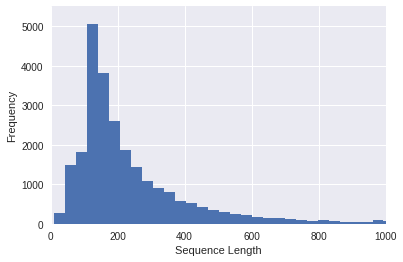

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(numWords, 75)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 1000, 0, 5500])
plt.show()

### We can see from the histogram how length of reviews is spread. We'll set up the max sequence length to 250 because most of the reviews are less than 250.

In [0]:
maxSeqLength = 250

Since we cannot store anything other than alphabets and numbers we need to clean the sentences and remove all the unwanted characters

In [0]:
# Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
import re
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

**Now let's convert all the training files. We'll load in the movie training set and integerize it to get a 25000 x 250 matrix.**

To create the word matrix file it takes long time so 

In [0]:
ids = np.zeros((numFiles, maxSeqLength), dtype='int32')
fileCounter = 0
for pf in positiveFiles:
   with open(pf, "r") as f:
       indexCounter = 0
       line=f.readline()
       cleanedLine = cleanSentences(line)
       split = cleanedLine.split()
       for word in split:
           try:
               ids[fileCounter][indexCounter] = wordsList.index(word)
           except ValueError:
               ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
           indexCounter = indexCounter + 1
           if indexCounter >= maxSeqLength:
               break
       fileCounter = fileCounter + 1 

for nf in negativeFiles:
   with open(nf, "r") as f:
       indexCounter = 0
       line=f.readline()
       cleanedLine = cleanSentences(line)
       split = cleanedLine.split()
       for word in split:
           try:
               ids[fileCounter][indexCounter] = wordsList.index(word)
           except ValueError:
               ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
           indexCounter = indexCounter + 1
           if indexCounter >= maxSeqLength:
               break
       fileCounter = fileCounter + 1 
#Pass into embedding function and see if it evaluates. 
np.save('aclImdb/ids_Matrix', ids)

In [0]:
ids = np.load('aclImdb/ids_Matrix.npy')

These functions will create training batches and testing batches and when called will return the words with sentiment lables

In [0]:
from random import randint

def getTrainBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        if (i % 2 == 0): 
            num = randint(1,11499)
            labels.append([1,0])
        else:
            num = randint(13499,24999)
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

def getTestBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        num = randint(11499,13499)
        if (num <= 12499):
            labels.append([1,0])
        else:
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

## Hyperparameters of Model


these are some of the defined hyperparameters:
* batch size, 
* number of LSTM units,
* number of output classes,
* number of training iterations. 




## Experiment 2 network configurations

In [0]:
batchSize = 32
lstmUnits = 50
numClasses = 2
iterations = 120001

In [0]:
import tensorflow as tf
tf.reset_default_graph()

labels = tf.placeholder(tf.float32, [batchSize, numClasses])
input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])

In [0]:
maxSeqLength = 250#Maximum length of sentence
numDimensions = 300 #Dimensions for each word vector
data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
data = tf.nn.embedding_lookup(wordVectors,input_data)

**Activation Function** - ReLU

In [0]:
lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits,activation='relu',reuse=True)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

Network Initializer - xavier

In [0]:
init = tf.contrib.layers.xavier_initializer()
weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]),initializer=init)
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

In [0]:
correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

* cost function - Cross entropy
* Optimizer -  Adam

In [0]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)

'''
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)
'''

Instructions for updating:
Use tf.cast instead.


'\nloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))\noptimizer = tf.train.AdamOptimizer().minimize(loss)\n'

## Intialize Tensorboard

In [0]:
import datetime
sess = tf.Session()
tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
merged = tf.summary.merge_all()
logdir = "tensorboard_experiment_relu+sigmoid_costFunction/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

In [0]:
from tqdm import tnrange

In [0]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())
#p_bar = tqdm(total=800)
for i in tnrange(iterations):
   #Next Batch of reviews
   nextBatch, nextBatchLabels = getTrainBatch();
   sess.run(optimizer, {input_data: nextBatch, labels: nextBatchLabels},)
   
   #Write summary to Tensorboard
   if (i % 50 == 0):
       summary = sess.run(merged, {input_data: nextBatch, labels: nextBatchLabels})
       writer.add_summary(summary, i)

   #Save the network every 10,000 training iterations
   if (i % 10000 == 0 and i != 0):
       save_path = saver.save(sess, "models_experiment2/pretrained_lstm.ckpt", global_step=i)
       print("saved to %s" % save_path)
writer.close()

Load the Trained model and create inference session

In [0]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint('models_experiment2'))

INFO:tensorflow:Restoring parameters from models_experiment2/pretrained_lstm.ckpt-120000


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [0]:
iterations = 10
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch();
    print("Accuracy for this batch:", (sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100)

Accuracy for this batch: 58.33333134651184
Accuracy for this batch: 62.5
Accuracy for this batch: 54.16666865348816
Accuracy for this batch: 58.33333134651184
Accuracy for this batch: 70.83333134651184
Accuracy for this batch: 54.16666865348816
Accuracy for this batch: 54.16666865348816
Accuracy for this batch: 58.33333134651184
Accuracy for this batch: 70.83333134651184
Accuracy for this batch: 83.33333134651184


## Accuracy of Sentiment analysis model 

![Image](Images/accuracyModel2.JPG)

## Loss vs Number of Epochs

![Image](Images/LossModel2.JPG)

## Conclusion

So far we have seen multiple components involved in sentiment analysis. When appropriate hyper-parameters are changed it changed the model training speed and performance of model. So finally we trained a model which is able to understand sentiments of movie reviews. 

The activation function function makes a big difference when it comes to training a network ReLu could not compete the accuracy of sigmoid function. ReLu takes a lot of time to train the network when compared to sigmoid.

Gradient estimator : Adam, in most of the cases performs better than RMSProp. However, in this case adam could not perform well. Adam was training the network rapidly but the testing accuracy was low. RMSProp was much slower compared to adam but accuracy after training was much better than adam

The loss functions did not make much difference in both of the experiments both of the loss functions were performing similarly.

Number of epochs depends on the type of network you set up. If the activation functions and gradient estimators are not well tuned then the same model would take a lot of epochs to train on contrary if network is designed well less number of epochs can give you well trained model.

The network initializers are used to define the initial values of the weights. There are many types of initializer available. The network worked best when the LeCunn uniform initializer was used.